In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import astropy.units as u
from  astropy.io import ascii
from spectral_cube import SpectralCube
from matplotlib import pyplot as plt
import numpy as np
from astropy.constants import c, h, k_B

In [3]:
from astropy.utils import data
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spo
import scipy.integrate as integrate
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import line_flux
from numpy.polynomial.polynomial import Polynomial
import regions

In [4]:
# redshift
# Emissions des poussieres (PAH) pour les bumps du continium (15 microns)), problème de stitching : 
# calibration a courte
# longueur d'onde la plus stable chanel 1 puis on ajuste les autres artefacts. 

# Setup

In [5]:
raies={7: 5.5115*u.um, 6: 6.1089*u.um, 5: 6.9091*u.um, 4: 8.0258*u.um, 3: 9.6649*u.um, 2: 12.2785*u.um, 1: 17.03484*u.um}

def getValues(obs: dict, obsNum: int):
    region_list = regions.Regions.read(f'observaciones/obs{obsNum}/subreg.reg')

    ch1 = SpectralCube.read(f'observaciones/obs{obsNum}/Level3_ch1-shortmediumlong_s3d.fits',hdu=1).subcube_from_regions(region_list)
    ch2 = SpectralCube.read(f'observaciones/obs{obsNum}/Level3_ch2-shortmediumlong_s3d.fits',hdu=1).subcube_from_regions(region_list)
    ch3 = SpectralCube.read(f'observaciones/obs{obsNum}/Level3_ch3-shortmediumlong_s3d.fits',hdu=1).subcube_from_regions(region_list)
    ch4 = SpectralCube.read(f'observaciones/obs{obsNum}/Level3_ch4-shortmediumlong_s3d.fits',hdu=1).subcube_from_regions(region_list)

    obs['channels']={1: ch1, 2: ch2, 3: ch3, 4: ch4}

    spectre_1 = ch1.mean(axis=(1, 2))
    spectre_2 = ch2.mean(axis=(1, 2))
    spectre_3 = ch3.mean(axis=(1, 2))
    spectre_4 = ch4.mean(axis=(1, 2))

    obs['spectres']={1: spectre_1, 2: spectre_2, 3: spectre_3, 4: spectre_4}

    S7_redshift = ch1.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[7])
    S6_redshift = ch1.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[6])
    S5_redshift = ch1.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[5])
    S4_redshift = ch2.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[4])
    S3_redshift = ch2.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[3])
    S2_redshift = ch3.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[2])
    S1_redshift = ch3.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=raies[1])

    obs['raies']={1: S1_redshift, 2: S2_redshift, 3: S3_redshift, 4: S4_redshift, 5: S5_redshift, 6: S6_redshift, 7: S7_redshift}

    spectre_S1_redshift = S1_redshift.mean(axis=(1, 2))
    spectre_S2_redshift = S2_redshift.mean(axis=(1, 2))
    spectre_S3_redshift = S3_redshift.mean(axis=(1, 2))
    spectre_S4_redshift = S4_redshift.mean(axis=(1, 2))
    spectre_S5_redshift = S5_redshift.mean(axis=(1, 2))
    spectre_S6_redshift = S6_redshift.mean(axis=(1, 2))
    spectre_S7_redshift = S7_redshift.mean(axis=(1, 2))

    obs['spectre raies']={1: spectre_S1_redshift, 2: spectre_S2_redshift, 3: spectre_S3_redshift, 
                        4: spectre_S4_redshift, 5: spectre_S5_redshift, 6: spectre_S6_redshift, 7: spectre_S7_redshift}

    S7_freq = S7_redshift.with_spectral_unit(u.Hz)
    S6_freq = S6_redshift.with_spectral_unit(u.Hz)
    S5_freq = S5_redshift.with_spectral_unit(u.Hz)
    S4_freq = S4_redshift.with_spectral_unit(u.Hz)
    S3_freq = S3_redshift.with_spectral_unit(u.Hz)
    S2_freq = S2_redshift.with_spectral_unit(u.Hz)
    S1_freq = S1_redshift.with_spectral_unit(u.Hz)

    obs['frequences']={1: S1_freq, 2: S2_freq, 3: S3_freq, 4: S4_freq, 5: S5_freq, 6: S6_freq, 7: S7_freq}

    spectre_S7_freq = S7_freq.mean(axis=(1, 2))
    spectre_S6_freq = S6_freq.mean(axis=(1, 2))
    spectre_S5_freq = S5_freq.mean(axis=(1, 2))
    spectre_S4_freq = S4_freq.mean(axis=(1, 2))
    spectre_S3_freq = S3_freq.mean(axis=(1, 2))
    spectre_S2_freq = S2_freq.mean(axis=(1, 2))
    spectre_S1_freq = S1_freq.mean(axis=(1, 2))

    obs['spectre frequences']={1: spectre_S1_freq, 2: spectre_S2_freq, 3: spectre_S3_freq, 
                        4: spectre_S4_freq, 5: spectre_S5_freq, 6: spectre_S6_freq, 7: spectre_S7_freq}

## Params

In [6]:
obs1=dict()
obs2=dict()
obs6=dict()
observations=[obs1, obs2, obs6]
obs_tags=[1,2,6]

for obs, i in zip(observations, obs_tags):
    getValues(obs, i)

In [15]:
def getChannel(raie):
    if raie in (1,2): return 3
    elif raie in (3,4): return 2
    elif raie in (5,6,7): return 1
    
crenS={1:[2220,2460], 2:[275,525], 3:[1700,1940], 4:[410,650], 5:[2575,2815], 6:[1265,1505], 7:[780,1020]}

xmin=4000
xmax=8500
ymin=-10
ymax=130
imax=len(raies)
jmax=len(observations)

# Exploration

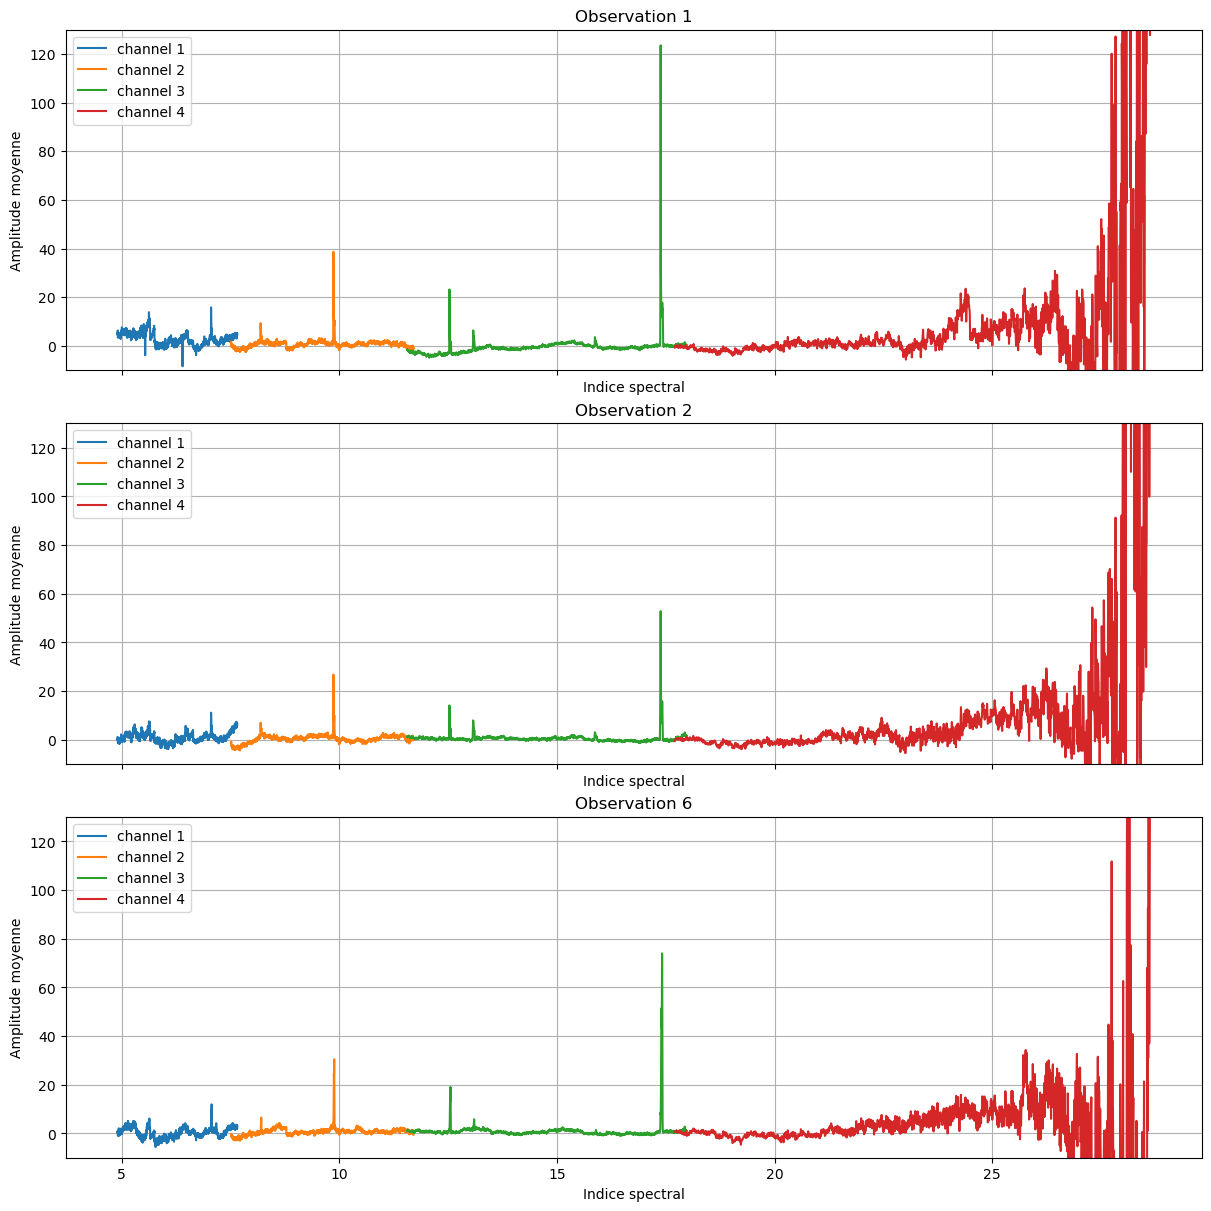

In [16]:
fig, axs = plt.subplots(jmax,1,figsize=(12,4*jmax),sharex=True,sharey=True,layout='constrained')

for j, obs in enumerate(observations):
    ax = axs[j]
    for ch in range(1,5):
        ax.plot(obs['channels'][ch].spectral_axis,obs['spectres'][ch],label=f'channel {ch}')
    ax.set_xlabel('Indice spectral')  # Modifier si ce sont des longueurs d'onde ou fréquences
    ax.set_ylabel('Amplitude moyenne')
    ax.legend()
    ax.grid()
    ax.set_ylim(ymin, ymax)
    ax.set_title(f'Observation {obs_tags[j]}')

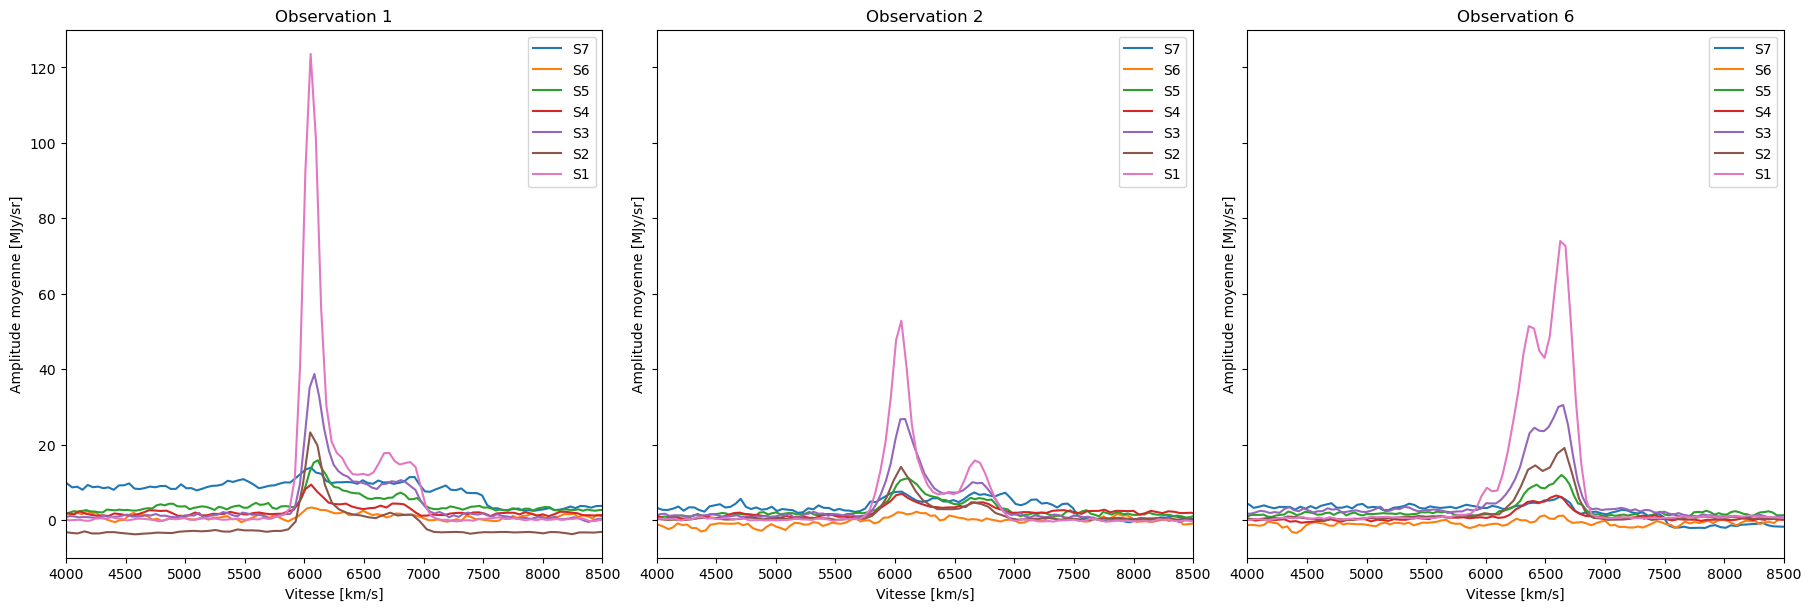

In [17]:
# Comparaison des raies pour les 2 régions
fig, axs = plt.subplots(1,jmax,figsize=(6*jmax,6),sharex=True,sharey=True, layout='constrained')

for j, obs in enumerate(observations):
    ax = axs[j]
    for r in raies:
        ax.plot(obs['raies'][r].spectral_axis,obs['spectre raies'][r],label=f'S{r}')
    ax.set_title(f'Observation {obs_tags[j]}')
    ax.set_xlabel('Vitesse [km/s]')  
    ax.set_ylabel('Amplitude moyenne [MJy/sr]')
    ax.legend()
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(xmin,xmax)


fig.savefig('identRaies.png')

# Flux

In [50]:
raies.pop(6)
imax=len(raies)

In [51]:
for obs in observations:
    obs['spectral_axis']=dict()
    obs['flux']=dict()
    obs['gaussian']=dict()
    for r in raies:
        spectral_axis = obs['spectre frequences'][r].spectral_axis[crenS[r][0]:crenS[r][1]]  # Axe spectral
        flux = obs['spectre frequences'][r].value[crenS[r][0]:crenS[r][1]] * u.MJy  # Flux 

        obs['spectral_axis'][r] = spectral_axis
        obs['flux'][r] = flux
        obs['gaussian'][r] = Spectrum1D(spectral_axis=spectral_axis, flux=flux)

In [52]:
# Calculer le flux dans une région spectrale définie
for j, obs in enumerate(observations):
    obs['region']=dict()
    obs['calculated_flux']=dict()
    obs['flux_in_wm2']=dict()
    for r in raies:   
        region = SpectralRegion(obs['gaussian'][r].spectral_axis.min(),obs['gaussian'][r].spectral_axis.max())
        calculated_flux = line_flux(obs['gaussian'][r], region)
        flux_in_wm2 = calculated_flux.to(u.W / (u.m**2))
        # print(f"Integrated flux Observation {obs_tags[j]} S{r}: {calculated_flux:.2e}" + str(' = ')  + f"{flux_in_wm2:.2e}")

        obs['region'][r] = region
        obs['calculated_flux'][r] = calculated_flux
        obs['flux_in_wm2'][r] = flux_in_wm2

In [ ]:
# Conversion
for j, obs in enumerate(observations):
    obs['I_obs']=dict()
    for r in raies:
        omega_pix = obs['channels'][getChannel(r)].header[30]
        N_pix = np.count_nonzero(~np.isnan(obs['frequences'][r].max(axis=0).value))

        I_obs = obs['flux_in_wm2'][r].value*omega_pix*N_pix
        obs['I_obs'][r] = I_obs
        
        print(f'I Observation {obs_tags[j]} S{r}: = ' + str("%.2e"%(I_obs)) + ' W/m2')

I Observation 1 S7: = 5.94e-17 W/m2
I Observation 1 S5: = 1.73e-17 W/m2
I Observation 1 S4: = 1.75e-17 W/m2
I Observation 1 S3: = 1.48e-17 W/m2
I Observation 1 S2: = -3.13e-17 W/m2
I Observation 1 S1: = 1.56e-17 W/m2
I Observation 2 S7: = 2.15e-17 W/m2
I Observation 2 S5: = 9.79e-18 W/m2
I Observation 2 S4: = 1.11e-17 W/m2
I Observation 2 S3: = 1.10e-17 W/m2
I Observation 2 S2: = 1.30e-17 W/m2
I Observation 2 S1: = 1.02e-17 W/m2
I Observation 6 S7: = 4.51e-18 W/m2
I Observation 6 S5: = 9.06e-18 W/m2
I Observation 6 S4: = 4.35e-18 W/m2
I Observation 6 S3: = 1.53e-17 W/m2
I Observation 6 S2: = 1.24e-17 W/m2
I Observation 6 S1: = 1.25e-17 W/m2


## Flux sans Continium

In [54]:
# Enlever le continium
for obs in observations:
    obs['continium']=dict()
    obs['corrected_flux']=dict()
    for r in raies:
        spectral_axis = obs['spectral_axis'][r]

        mask = (spectral_axis < obs['gaussian'][r].spectral_axis[-100]) | (spectral_axis > obs['gaussian'][r].spectral_axis[100])
        p = Polynomial.fit(spectral_axis[mask].value, obs['gaussian'][r].flux[mask].value, deg=2)
        continium = p(spectral_axis.value)* u.MJy
        corrected_flux = obs['gaussian'][r].flux - continium 
        
        obs['continium'][r]=continium
        obs['corrected_flux'][r]=corrected_flux

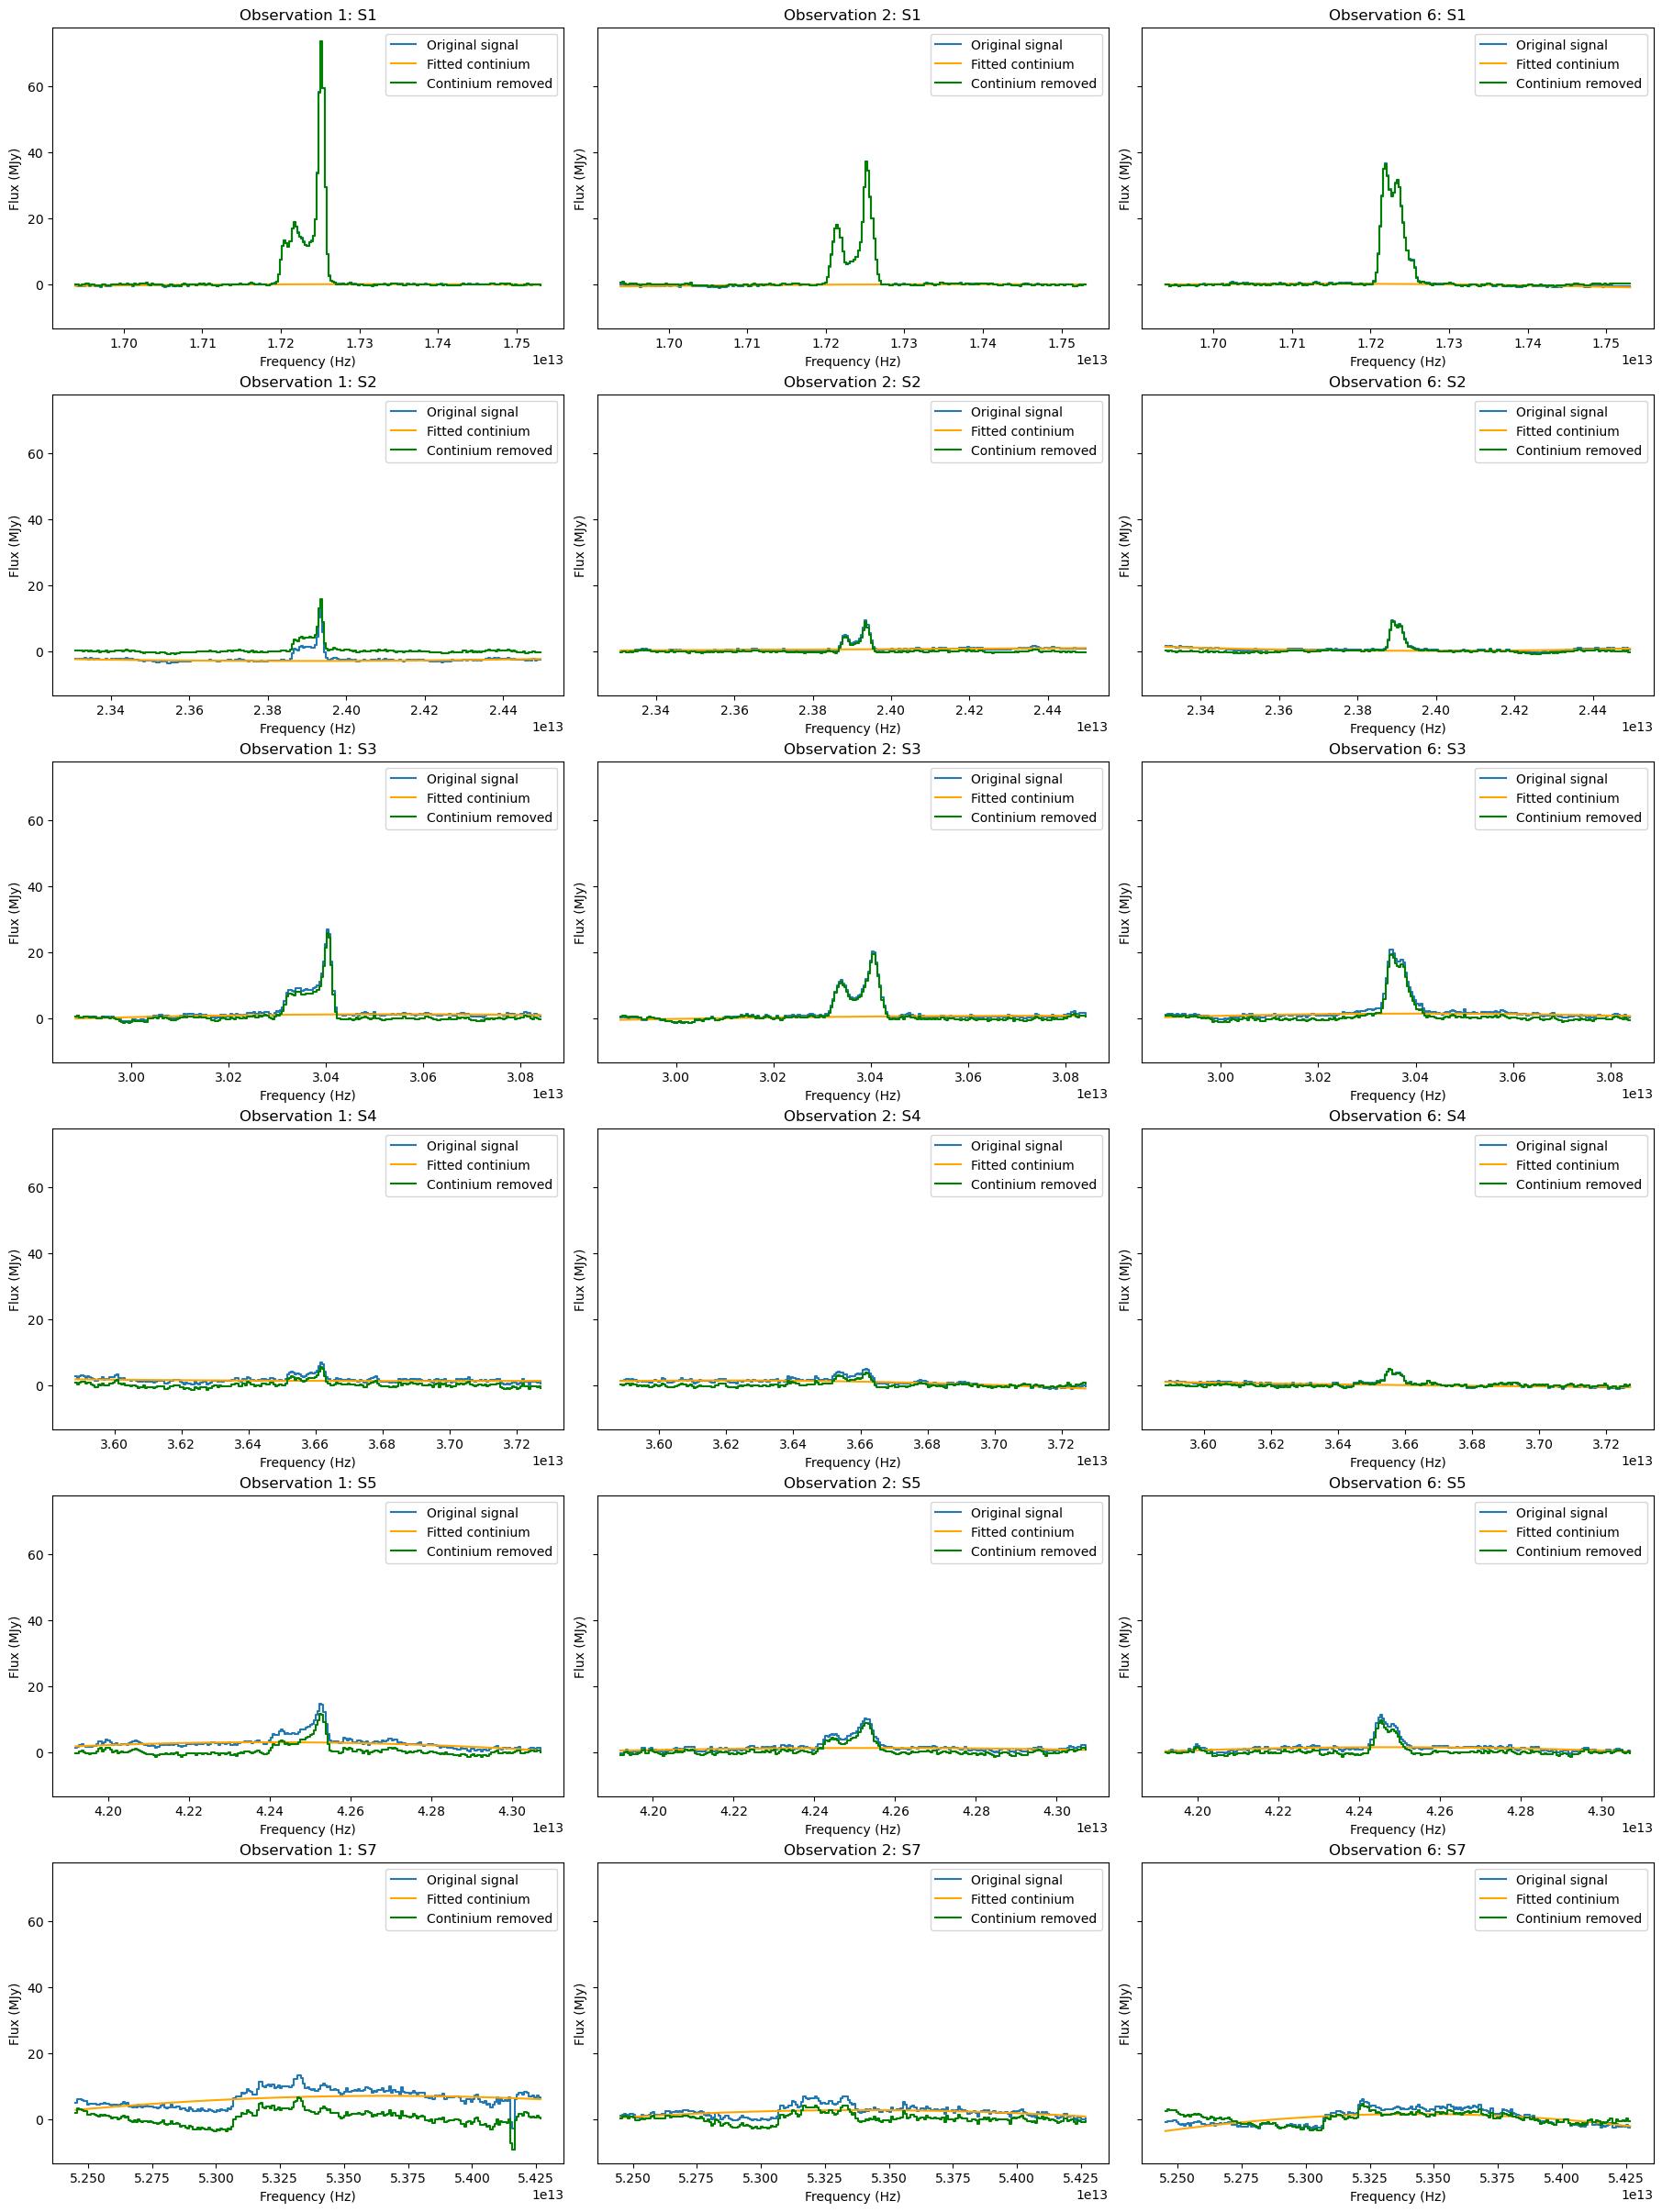

In [ ]:
# Visualiser
fig, axs = plt.subplots(nrows=imax,ncols=jmax,figsize=(jmax*6,imax*4),
                        sharey=True, 
                        layout='constrained')

for j, obs in enumerate(observations):
    for r in raies:
        ax=axs[5 if r==7 else r-1][j]

        ax.step(obs['spectral_axis'][r], obs['gaussian'][r].flux, label='Original signal')
        ax.plot(obs['spectral_axis'][r], obs['continium'][r], label='Fitted continium', color='orange')
        ax.step(obs['spectral_axis'][r], obs['corrected_flux'][r], label='Continium removed', color='green')

        ax.set_title(f'Observation {obs_tags[j]}: S{r}')
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Flux (MJy)")
        ax.legend()

In [56]:
for obs in observations:
    obs['corrected_gaussian']=dict()
    for r in raies:
        obs['corrected_gaussian'][r] = Spectrum1D(spectral_axis=obs['spectral_axis'][r],
                                                  flux=obs['corrected_flux'][r])

In [57]:
# Calculer le flux dans une région spectrale définie
for obs in observations:
    obs['flux_in_wm2_corr']=dict()
    for r in raies:
        region = SpectralRegion(obs['gaussian'][r].spectral_axis[100],obs['gaussian'][r].spectral_axis[-100])
        calculated_flux = line_flux(obs['corrected_gaussian'][r], region)
        flux_in_wm2_corr = calculated_flux.to(u.W / (u.m**2))
        # print(f"Integrated flux Observation 1 S1: {calculated_flux:.2e}" + str(' = ')  + f"{flux_in_wm2_corr:.2e}")
        
        obs['flux_in_wm2_corr'][r]=flux_in_wm2_corr

In [58]:
# Conversion
for j, obs in enumerate(observations):
    obs['I_obs_corr']=dict()
    for r in raies:
        omega_pix = obs['channels'][getChannel(r)].header[30]
        N_pix = np.count_nonzero(~np.isnan(obs['frequences'][r].max(axis=0).value))

        I_obs_corr = obs['flux_in_wm2_corr'][r]*omega_pix*N_pix
        obs['I_obs_corr'][r] = I_obs_corr
        
        print(f'I Observation {obs_tags[j]} S{r}: =', I_obs_corr)

I Observation 1 S7: = 4.820353918245496e-18 W / m2
I Observation 1 S5: = 3.320651543465283e-18 W / m2
I Observation 1 S4: = 2.520769796674643e-18 W / m2
I Observation 1 S3: = 8.036057163363247e-18 W / m2
I Observation 1 S2: = 6.054550947773462e-18 W / m2
I Observation 1 S1: = 1.569289290154579e-17 W / m2
I Observation 2 S7: = 2.4217319843722766e-18 W / m2
I Observation 2 S5: = 3.3502662253522826e-18 W / m2
I Observation 2 S4: = 2.2448401003795326e-18 W / m2
I Observation 2 S3: = 7.94667077781373e-18 W / m2
I Observation 2 S2: = 3.507193223168075e-18 W / m2
I Observation 2 S1: = 1.0797740071938748e-17 W / m2
I Observation 6 S7: = 3.0907297692021315e-18 W / m2
I Observation 6 S5: = 2.34261883517439e-18 W / m2
I Observation 6 S4: = 2.4777973928135847e-18 W / m2
I Observation 6 S3: = 7.156758709445234e-18 W / m2
I Observation 6 S2: = 4.8968744514938934e-18 W / m2
I Observation 6 S1: = 1.2725576506601519e-17 W / m2


# Diagramme d'Excitation

In [59]:
# y-axis: ln(Nup/gup), x-axis: Eup/kB
def g(J):
    return J*(2*J+1)

def N(A, lbda, I):
    return 4*np.pi*lbda / (c*h) * I/A

E_up = {1:1015.0*u.K, 2:1682.0*u.K, 3:2503.4*u.K, 4:3474.6*u.K, 5:4586.7*u.K, 6:5829.8*u.K, 7:7196.6*u.K}
A_ij = {1: 4.76e-10*u.Hz, 2:2.76e-9*u.Hz, 3:9.84e-9*u.Hz, 4:2.64e-8*u.Hz, 5:5.88e-8*u.Hz, 6:1.14e-7*u.Hz, 7:2.00e-7*u.Hz}
g_up = dict((r, g(r+2)) for r in raies)
xaxis=[E_up[r].value for r in raies]

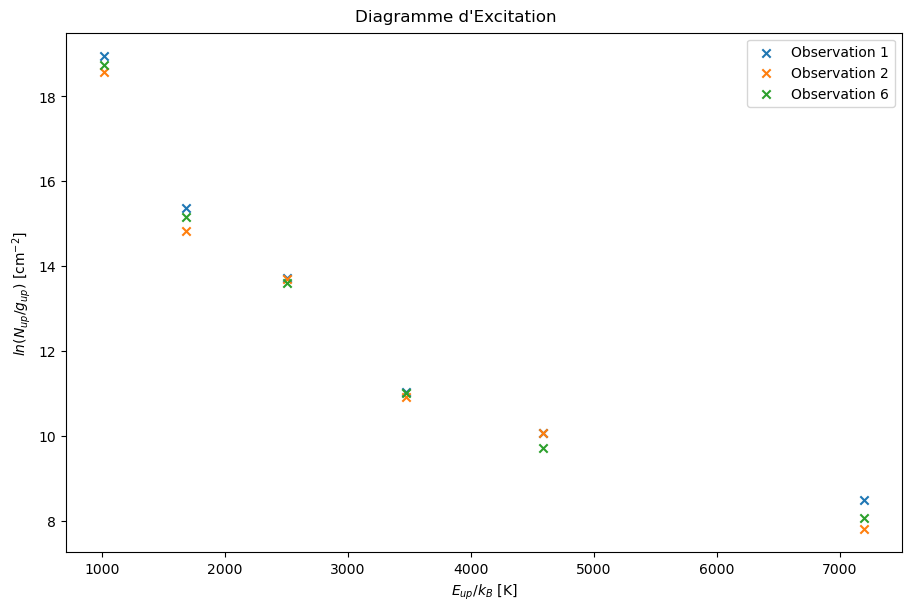

In [60]:
fig, ax = plt.subplots(figsize=(9,6), layout='constrained')

for obs, j in zip(observations, obs_tags):
    N_up = dict((r, N(A_ij[r], raies[r], obs['I_obs_corr'][r]).to(1/u.cm*1/u.cm)) for r in raies)
    
    yaxis_ln=[np.log(N_up[r].value/g_up[r]) for r in raies]
    ax.scatter(xaxis, yaxis_ln, label=f'Observation {j}', marker='x')

fig.suptitle(f"Diagramme d'Excitation")
ax.set_xlabel("$E_{up}/k_B$ [K]")
ax.set_ylabel("$ln(N_{up}/g_{up})$ [cm$^{-2}$]")
ax.legend()

fig.savefig('diagExcit.png')

obs: 1 Raie: 7 = 8.40e+05 1 / cm2
obs: 1 Raie: 5 = 2.47e+06 1 / cm2
obs: 1 Raie: 4 = 4.85e+06 1 / cm2
obs: 1 Raie: 3 = 4.99e+07 1 / cm2
obs: 1 Raie: 2 = 1.70e+08 1 / cm2
obs: 1 Raie: 1 = 3.55e+09 1 / cm2
obs: 2 Raie: 7 = 4.22e+05 1 / cm2
obs: 2 Raie: 5 = 2.49e+06 1 / cm2
obs: 2 Raie: 4 = 4.32e+06 1 / cm2
obs: 2 Raie: 3 = 4.94e+07 1 / cm2
obs: 2 Raie: 2 = 9.87e+07 1 / cm2
obs: 2 Raie: 1 = 2.44e+09 1 / cm2
obs: 6 Raie: 7 = 5.39e+05 1 / cm2
obs: 6 Raie: 5 = 1.74e+06 1 / cm2
obs: 6 Raie: 4 = 4.77e+06 1 / cm2
obs: 6 Raie: 3 = 4.45e+07 1 / cm2
obs: 6 Raie: 2 = 1.38e+08 1 / cm2
obs: 6 Raie: 1 = 2.88e+09 1 / cm2


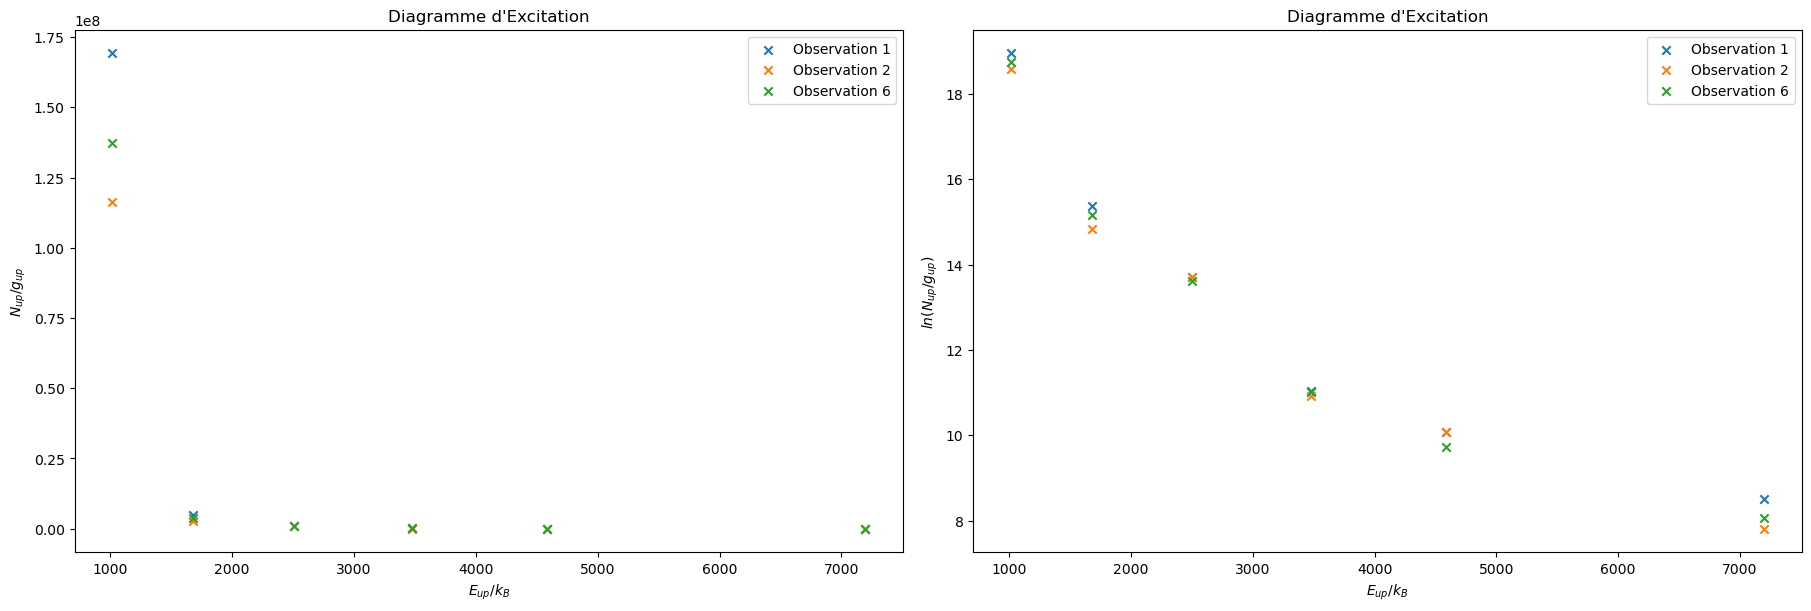

In [61]:
fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(9*2,6), layout='constrained')

for obs, j in zip(observations, obs_tags):
    N_up = dict((r, N(A_ij[r], raies[r], obs['I_obs_corr'][r]).to(1/u.cm*1/u.cm)) for r in raies)
    
    for p in N_up: print('obs:',j,'Raie:',p, "=",f"{N_up[p].value:.2e}",N_up[p].unit)

    yaxis=[N_up[r].value/g_up[r] for r in raies]
    yaxis_ln=[np.log(N_up[r].value/g_up[r]) for r in raies]
    
    axs[0].scatter(xaxis, yaxis, label=f'Observation {j}', marker='x')
    axs[1].scatter(xaxis, yaxis_ln, label=f'Observation {j}', marker='x')

    axs[0].set_ylabel("$N_{up}/g_{up}$")
    axs[1].set_ylabel("$ln(N_{up}/g_{up})$")

for ax in axs:
    ax.set_title(f"Diagramme d'Excitation")
    ax.set_xlabel("$E_{up}/k_B$")
    ax.legend()